In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary

In [2]:
TRAIN_DATA_PATH = "data/train"
TEST_DATA_PATH = "data/test"
VAL_DATA_PATH = "data/val"

# Посмотрим на исходные данные

In [3]:
def show_random_image(path):
    random_image_name = np.random.choice(os.listdir(path))
    image = mpimg.imread(os.path.join(path, random_image_name))
    plt.figure(figsize=(4, 5))
    plt.title(os.path.join(path, random_image_name))
    # plt.xlabel("X pixel scaling")
    # plt.ylabel("Y pixels scaling")
    plt.imshow(image)
    plt.show() 

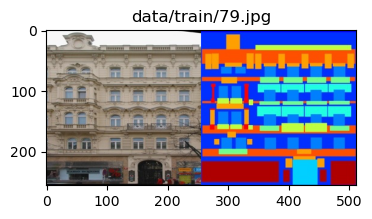

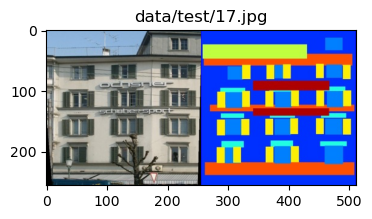

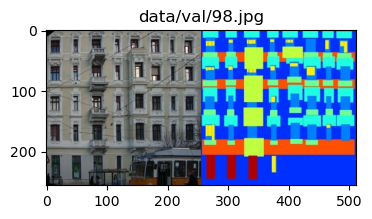

In [4]:
show_random_image(TRAIN_DATA_PATH)
show_random_image(TEST_DATA_PATH)
show_random_image(VAL_DATA_PATH)

# Подготовка датасета + аугментации

In [4]:
class FacadeDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.n_samples = os.listdir(self.root_dir)
        
    def __len__(self):
        return len(self.n_samples)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() 
        image_name = self.n_samples[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = np.asarray(Image.open(image_path).convert("RGB"))
        height, width, _ = image.shape
        width_cutoff = width // 2
        real_image = image[:, :width_cutoff, :]
        input_image = image[:, width_cutoff:, :]
        sample = {
            "input_image": input_image, 
            "real_image": real_image
        }
        
        if self.transform:
            sample = self.transform(sample)  
        
        return sample


In [5]:
class Resize:
    
    def __init__(self, output_size=284):
        self.output_size = output_size

    def __call__(self, sample):
        sample["input_image"] = cv2.resize(
            sample["input_image"], (self.output_size, self.output_size)
        )
        sample["real_image"] = cv2.resize(
            sample["real_image"], (self.output_size, self.output_size)
        )
        return sample
    
    
class RandomCrop:
    
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        h, w = sample["real_image"].shape[:2]
        top = np.random.randint(0, h - self.output_size)
        left = np.random.randint(0, w - self.output_size)
        sample["input_image"] = sample["input_image"][
            top: top + self.output_size,
            left: left + self.output_size
        ]  
        sample["real_image"] = sample["real_image"][
            top: top + self.output_size,
            left: left + self.output_size
        ]
        return sample
    

class RandomHorizontalFlip:
    
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        if np.random.random() > self.p:
            sample["input_image"] = cv2.flip(sample["input_image"], 1)
            sample["real_image"] = cv2.flip(sample["real_image"], 1)
        return sample
    
    
class Normalize:
    def __call__(self, sample):
        sample["input_image"] = sample["input_image"] / 127.5 - 1
        sample["real_image"] = sample["real_image"] / 127.5 - 1
        return sample
    
    
class ToTensor:
    # numpy image: H x W x C
    # torch image: C x H x W
    def __call__(self, sample):
        sample["input_image"] = sample["input_image"].transpose((2, 0, 1)).astype(np.float32)
        sample["input_image"] = torch.from_numpy(sample["input_image"])
        sample["real_image"] = sample["real_image"].transpose((2, 0, 1)).astype(np.float32)
        sample["real_image"] = torch.from_numpy(sample["real_image"])
        return sample
    

In [6]:
def get_dataloader(path, batch_size=8, num_workers=0, val=False):
    
    if not val:
        train_transform = transforms.Compose(
            [
                Resize(284), 
                RandomCrop(256),
                RandomHorizontalFlip(0.5),
                Normalize(),
                ToTensor(),
            ]
        )
        dataset = FacadeDataset(root_dir=path, transform=train_transform)
        dataloader = DataLoader(
            dataset, 
            batch_size=batch_size,
            shuffle=True, 
            drop_last=True,
            num_workers=num_workers,
        )  
    else:
        val_transform = transforms.Compose(
            [
                Normalize(),
                ToTensor(),
            ]
        )
        dataset = FacadeDataset(root_dir=path, transform=val_transform)
        dataloader = DataLoader(
            dataset, 
            batch_size=batch_size,
            shuffle=False, 
            drop_last=False,
            num_workers=num_workers,
        )
        
    return dataloader

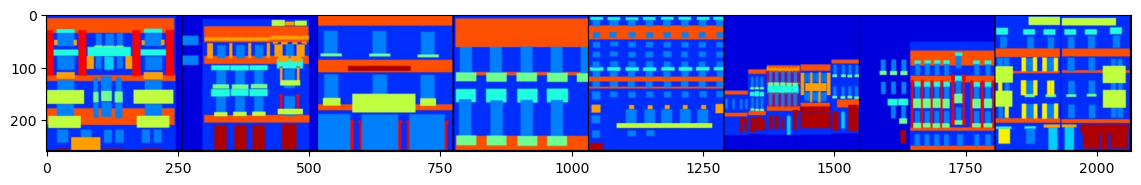

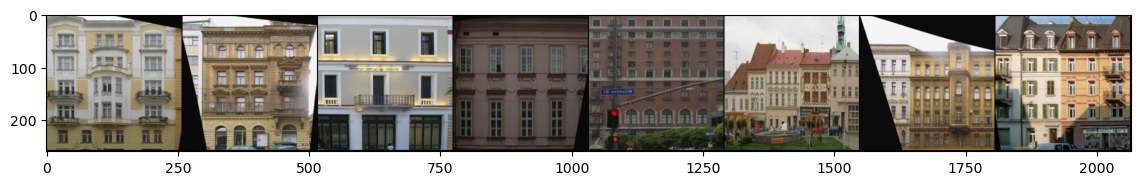

In [8]:
train_dataloader = get_dataloader(TRAIN_DATA_PATH)


for batch in train_dataloader:
    input_image_batch, real_image_batch = batch["input_image"], batch["real_image"]
    
    input_image_batch = ((input_image_batch + 1) * 127.5).int()
    real_image_batch = ((real_image_batch + 1) * 127.5).int()
    
    grid = utils.make_grid(input_image_batch)
    plt.figure(figsize=(14, 5))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    grid = utils.make_grid(real_image_batch)
    plt.figure(figsize=(14, 5))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break

# Генератор

In [7]:
class BlockDown(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=2, padding=1, use_batch_norm=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=4, 
                stride=stride, 
                padding=padding, 
                bias=False, 
                padding_mode="reflect"
            )
        )
        if use_batch_norm:
            self.conv.append(nn.BatchNorm2d(out_channels))
        self.conv.append(nn.LeakyReLU(0.2))
        nn.init.normal_(self.conv[0].weight, 0, 0.02)
    
    def forward(self,x):
        x = self.conv(x)
        return x
    
    
class BlockUp(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=2, padding=1, use_batch_norm=True, use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=4, 
                stride=stride, 
                padding=padding, 
                bias=False,
            )
        )
        if use_batch_norm:
            self.conv.append(nn.BatchNorm2d(out_channels))
        if use_dropout:
            self.conv.append(nn.Dropout(0.5))
        self.conv.append(nn.ReLU())
        nn.init.normal_(self.conv[0].weight, 0, 0.02)
    
    def forward(self,x):
        x = self.conv(x)
        return x


class Generator(nn.Module):
    ### Unet
    
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        
        ##############################################################################
        ################################## ENCODER ###################################
        ##############################################################################
        self.down1 = BlockDown(in_channels, features, use_batch_norm=False)  # 64 X 128 X 128
        self.down2 = BlockDown(features, 2 * features)  # 128 X 64 X 64
        self.down3 = BlockDown(2 * features, 4 * features)  # 256 X 32 X 32
        self.down4 = BlockDown(4 * features, 8 * features)  # 512 X 16 X 16
        self.down5 = BlockDown(8 * features, 8 * features)  # 512 X 8 X 8
        self.down6 = BlockDown(8 * features, 8 * features)  # 512 X 4 X 4
        self.down7 = BlockDown(8 * features, 8 * features)  # 512 X 2 X 2
        self.bottleneck = BlockDown(8 * features, 8 * features)  # 512 X 1 X 1
        
        ##############################################################################
        ################################## DECODER ###################################
        ##############################################################################
        self.up1 = BlockUp(8 * features, 8 * features, use_dropout=True)
        self.up2 = BlockUp(16 * features, 8 * features, use_dropout=True)
        self.up3 = BlockUp(16 * features, 8 * features, use_dropout=True)
        self.up4 = BlockUp(16 * features, 8 * features)
        self.up5 = BlockUp(16 * features, 4 * features)
        self.up6 = BlockUp(8 * features, 2 * features)
        self.up7 = BlockUp(4 * features, features)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(2 * features, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        nn.init.normal_(self.final_up[0].weight, 0, 0.02)
        
    def forward(self,x):
        
        # encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        bottleneck = self.bottleneck(d7)
        
        # decoder
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        final_up = self.final_up(torch.cat([u7, d1], 1))
        
        return final_up
        

# Дискриминатор

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, in_channels=3, features = [64, 128, 256, 512]):
        super().__init__()
        self.down1 = BlockDown(2 * in_channels, features[0], use_batch_norm=False)
        self.down2 = BlockDown(features[0], features[1])
        self.down3 = BlockDown(features[1], features[2])
        self.down4 = BlockDown(features[2], features[3], stride=1)
        self.down5 = BlockDown(features[3], 1, stride=1, use_batch_norm=False)
        
    def forward(self, inp, tar):
        ### inp = input image
        ### tar = correct/fake image
        x = torch.cat([inp, tar], 1)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        x = self.down5(x)
        return x
    

# Функция потерь

In [9]:
def generator_loss(real_image, fake_image, discr_fake, bce_loss, l1_loss, lambda_coef):
    """Функция потерь для генератора."""
    
    gan_loss = bce_loss(discr_fake, torch.ones_like(discr_fake))
    
    total_loss =  gan_loss + lambda_coef * l1_loss(fake_image, real_image)
 
    return total_loss
     

def discriminator_loss(discr_real, discr_fake, bce_loss, coef=.5):
    """Функция потерь для дискриминатора."""
    
    real_loss = bce_loss(discr_real, torch.ones_like(discr_real))
    fake_loss = bce_loss(discr_fake, torch.zeros_like(discr_fake))

    total_loss = coef * (real_loss + fake_loss)
    
    return total_loss


# Тренировка

In [10]:
BATCH_SIZE = 8
NUM_WORKERS = 4
LAMBDA = 100
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999
N_EPOCHS = 1

In [11]:
generator = Generator()
discriminator = Discriminator()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))

bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

train_dataloader = get_dataloader(TRAIN_DATA_PATH, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, val=False)
val_dataloader = get_dataloader(VAL_DATA_PATH, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, val=True)

In [12]:
def step(generator, discriminator, batch):
    
    input_image, real_image = batch["input_image"], batch["real_image"]

    # train discriminator
    fake_image = generator(input_image)
    d_real = discriminator(input_image, real_image)
    d_fake = discriminator(input_image, fake_image.detach())
    d_loss = discriminator_loss(d_real, d_fake, bce_loss, coef=0.5)
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # train generator
    d_fake = discriminator(input_image, fake_image)
    g_loss = generator_loss(real_image, fake_image, d_fake, bce_loss, l1_loss, LAMBDA)
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    
    return d_loss.item(), g_loss.item()


def plot_generator_results(dataloader, generator):
    
    for batch in dataloader:
        break

    input_image_batch, real_image_batch = batch["input_image"], batch["real_image"]
    fake_image_batch = generator(input_image_batch)

    input_image_batch = ((input_image_batch + 1) * 127.5).int()
    real_image_batch = ((real_image_batch + 1) * 127.5).int()
    fake_image_batch = ((fake_image_batch + 1) * 127.5).int()

    grid = utils.make_grid(input_image_batch)
    plt.figure(figsize=(14, 5))
    plt.title("INPUT IMAGES")
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    grid = utils.make_grid(real_image_batch)
    plt.figure(figsize=(14, 5))
    plt.title("REAL IMAGES")
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    grid = utils.make_grid(fake_image_batch)
    plt.figure(figsize=(14, 5))
    plt.title("GENERATED IMAGES")
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    

In [13]:
dis_loss = []
gen_loss = []

for epoch in range(N_EPOCHS):
    
    pbar = tqdm(train_dataloader)
    pbar.set_description(f"epoch={epoch}")
    
    for batch in pbar:
        
        d_loss, g_loss = step(generator, discriminator, batch)
        dis_loss.append(d_loss)
        gen_loss.append(g_loss)
        pbar.set_postfix(d_loss=d_loss, g_loss=g_loss)
        
    if epoch % 10 == 0:
        torch.save(generator, "generator_epoch_1.pkl")
        torch.save(discriminator, "discriminator_epoch_1.pkl")
        

epoch=0: 100%|██████████████████████████████████████████████████████████████████| 50/50 [03:56<00:00,  4.74s/it, d_loss=0.899, g_loss=34.9]


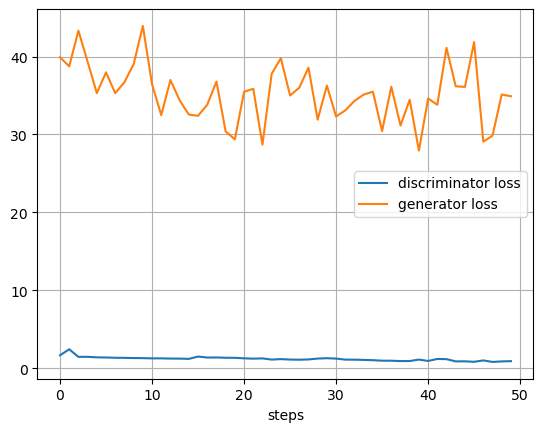

In [14]:
plt.plot(dis_loss, label="discriminator loss")
plt.plot(gen_loss, label="generator loss")
plt.xlabel("steps")
plt.grid()
plt.legend();

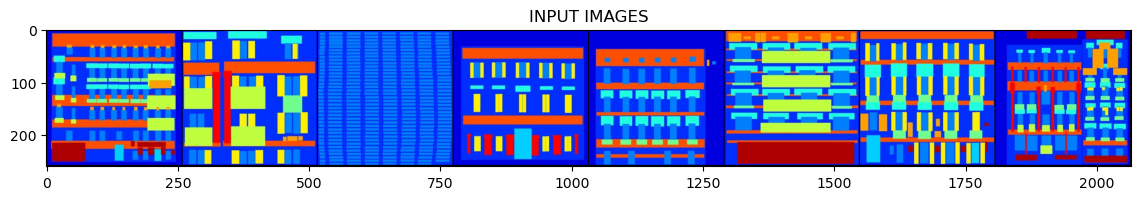

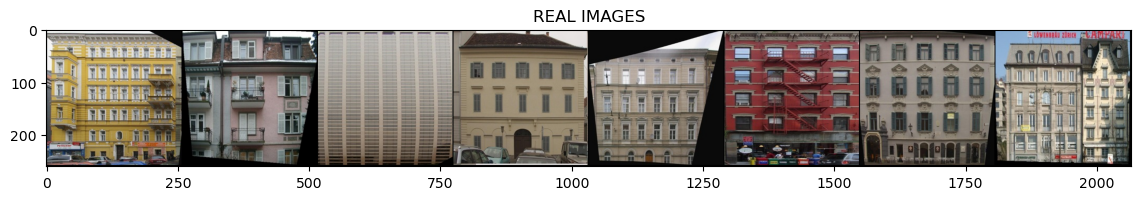

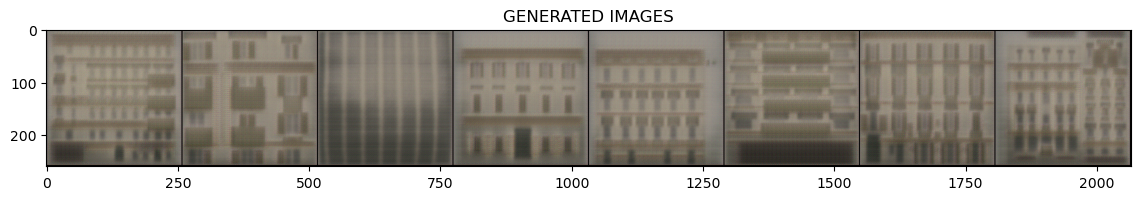

In [15]:
plot_generator_results(val_dataloader, generator)